In [1]:
import os
from pathlib import Path
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 12-2 (Indexing - Multi-Vector (Chunks))"

In [4]:
DATA_PATH = Path('../../data')

# Indexing

![](images/indexing-01.png)

# Part 12-2: Multi-Vector (Chunks)

![](images/12-02-multi-vector-chunks.png)

## Configure components

In [5]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [6]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BKP3nUyW5fUrDbeqNkoEN51aFxINn', 'finish_reason': 'stop', 'logprobs': None}, id='run-85c1bb5d-248c-43ef-91f1-cc30b4934713-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [8]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [9]:
articles = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-02-05-human-data-quality/",
]

loader = WebBaseLoader(
    web_paths=articles,
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

2

In [10]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

In [11]:
print(docs[1].page_content[:1000])



      Thinking about High-Quality Human Data
    
Date: February 5, 2024  |  Estimated Reading Time: 21 min  |  Author: Lilian Weng


[Special thank you to Ian Kivlichan for many useful pointers (E.g. the 100+ year old Nature paper “Vox populi”) and nice feedback. 🙏 ]
High-quality data is the fuel for modern data deep learning model training. Most of the task-specific labeled data comes from human annotation, such as classification task or RLHF labeling (which can be constructed as classification format) for LLM alignment training. Lots of ML techniques in the post can help with data quality, but fundamentally human data collection involves attention to details and careful execution. The community knows the value of high quality data, but somehow we have this subtle impression that “Everyone wants to do the model work, not the data work” (Sambasivan et al. 2021).

Fig. 1. Two directions to approach high data quality.
Human Raters ↔ Data Quality#


In [12]:
[len(doc.page_content) for doc in docs]

[43130, 29018]

## Split documents

In [13]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [14]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=10000, chunk_overlap=0)
splits = text_splitter.split_documents(docs)
len(splits)

8

## Store documents

In [15]:
from operator import attrgetter
import uuid

from langchain_core.documents import Document
from langchain_core.stores import InMemoryByteStore
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [16]:
vectorstore = InMemoryVectorStore(embeddings)
store = InMemoryByteStore()
id_key = "split_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

split_ids = [str(uuid.uuid4()) for _ in splits]

child_text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)

all_sub_splits = []

for i, split in enumerate(splits):
    split_id = split_ids[i]
    sub_splits = child_text_splitter.split_documents([split])
    
    for sub_split in sub_splits:
        sub_split.metadata[id_key] = split_id
        
    all_sub_splits.extend(sub_splits)

retriever.vectorstore.add_documents(all_sub_splits)
print(len(all_sub_splits), len(retriever.vectorstore.store))

retriever.docstore.mset(list(zip(split_ids, splits)))
print(len(split_ids), len(list(retriever.docstore.store.yield_keys())))

103 103
8 8


In [17]:
agent_query = "What is task decomposition for LLM agents?"
human_data_query = "What are main steps for collecting human data?"

In [18]:
rprint(agent_query)

response = retriever.vectorstore.similarity_search(agent_query)
rprint(Pretty(response, no_wrap=False))

chunk_pattern = re.compile(r'^Chunk \d+.*:$', flags=re.MULTILINE)
terms_pattern = re.compile(rf'\b({"|".join(agent_query.split())})\b', flags=re.IGNORECASE)

for chunk_id, doc in enumerate(response, start=1):
    text = Text(f"Chunk {chunk_id}:\n{doc.page_content}")
    text.highlight_regex(chunk_pattern, "bold green")
    text.highlight_regex(terms_pattern, "underline red")
    rprint(text)

response = retriever.invoke(agent_query)
rprint(Pretty(response, max_string=1000, no_wrap=False))

What is task decomposition for LLM agents?

[
    Document(
        id='c4ce6ad2-f138-4d89-9f78-5fbfd31a5da7',
        metadata={
            'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
            'split_id': '7cb07ff1-7542-400a-859c-053b6e43479c'
        },
        page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA 
complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask 
Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing 
model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time 
computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple 
manageable tasks and shed lights into an interpretation of the model’s thinking process.'
    ),
    Document(
        id='069cc00f-92fd-41ae-a8b0-a6a0c63441a4',
        metadata={
            'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
            'split_id': '7cb07ff1-7542-400a-859c-053b6e43479c'
        },
        page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  
|  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool 
concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. 
The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be 
framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM
functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: 
The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex 
tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn 
from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
    ),
    Document(
        id='eb349b95-5398-44f4-8bc7-4c8669d9bb5e',
        metadata={
            'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
            'split_id': '3d1901df-c520-4c54-8820-b5971f52380c'
        },
        page_content='Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)\nThe system 
comprises of 4 stages:\n(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks.
There are four attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot 
examples to guide LLM to do task parsing and planning.\nInstruction:'
    ),
    Document(
        id='bcd20973-d3ab-4f4c-9c78-322f66d4f4ca',
        metadata={
            'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
            'split_id': '7cb07ff1-7542-400a-859c-053b6e43479c'
        },
        page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities 
at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step,
creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with 
each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM 
with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using 
task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'
    )
]

Chunk 1:
Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance 
on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to 
decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and 
shed lights into an interpretation of the model’s thinking process.

Chunk 2:
LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts
demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends 
beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem
solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key 
components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient 
handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from 
mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Chunk 3:
Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)
The system comprises of 4 stages:
(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four 
attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to 
guide LLM to do task parsing and planning.
Instruction:

Chunk 4:
Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first
decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree 
structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state 
evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals 
for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or
(3) with human inputs.

[
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  
|  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool 
concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. 
The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be 
framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM
functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: 
The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex 
tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn 
from mistakes and refine them for future steps, thereby improving the quality of final 
results.\n\n\nMemory\n\nShort-term memory: I would co'+8746
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Fig. 7. Comparison of AD, ED, source policy and RL^2 on environments that require memory and 
exploration. Only binary reward is assigned. The source policies are trained with A3C for "dark" environments and 
DQN for watermaze.(Image source: Laskin et al. 2023)\nComponent Two: Memory#\n(Big thank you to ChatGPT for helping
me draft this section. I’ve learned a lot about the human brain and data structure for fast MIPS in my 
conversations with ChatGPT.)\nTypes of Memory#\nMemory can be defined as the processes used to acquire, store, 
retain, and later retrieve information. There are several types of memory in human brains.\n\n\nSensory Memory: 
This is the earliest stage of memory, providing the ability to retain impressions of sensory information (visual, 
auditory, etc) after the original stimuli have ended. Sensory memory typically only lasts for up to a few seconds. 
Subcategories include iconic memory (visual), echoic memory (auditory), and haptic memory (touch).\n\n\nShort-Term 
Memory (STM) or W'+8709
    )
]

In [19]:
rprint(human_data_query)

response = retriever.vectorstore.similarity_search(human_data_query)
rprint(Pretty(response, no_wrap=False))

chunk_pattern = re.compile(r'^Chunk \d+.*:$', flags=re.MULTILINE)
terms_pattern = re.compile(rf'\b({"|".join(human_data_query.split())})\b', flags=re.IGNORECASE)

for chunk_id, doc in enumerate(response, start=1):
    text = Text(f"Chunk {chunk_id}:\n{doc.page_content}")
    text.highlight_regex(chunk_pattern, "bold green")
    text.highlight_regex(terms_pattern, "underline red")
    rprint(text)

response = retriever.invoke(agent_query)
rprint(Pretty(response, max_string=1000, no_wrap=False))

What are main steps for collecting human data?

[
    Document(
        id='17741deb-555b-42e6-9d3c-d66395f8ef40',
        metadata={
            'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/',
            'split_id': 'e1ceb846-4f31-499b-82de-5fbb14f27d22'
        },
        page_content='Fig. 1. Two directions to approach high data quality.\nHuman Raters ↔ Data 
Quality#\nCollecting human data involve a set of operation steps and every step contributes to the data 
quality:\n\nTask design: Design task workflow to improve clarity and reduce complexity. Detailed guidelines are 
helpful but very long and complicated guidelines demand a decent amount of training to be useful.\nSelect and train
a pool of raters: Select annotators with matched skillset and consistency. Training sessions are necessary. After 
onboarding, regular feedback and calibration sessions are also needed.\nCollect and aggregate data. This is the 
stage where more ML techniques can be applied to clean, filter and smartly aggregate data to identify the true 
labels.'
    ),
    Document(
        id='8784a472-61c6-4eb8-8475-b914a3c36e86',
        metadata={
            'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/',
            'split_id': 'e1ceb846-4f31-499b-82de-5fbb14f27d22'
        },
        page_content='Thinking about High-Quality Human Data\n    \nDate: February 5, 2024  |  Estimated Reading 
Time: 21 min  |  Author: Lilian Weng\n\n\n[Special thank you to Ian Kivlichan for many useful pointers (E.g. the 
100+ year old Nature paper “Vox populi”) and nice feedback. 🙏 ]\nHigh-quality data is the fuel for modern data 
deep learning model training. Most of the task-specific labeled data comes from human annotation, such as 
classification task or RLHF labeling (which can be constructed as classification format) for LLM alignment 
training. Lots of ML techniques in the post can help with data quality, but fundamentally human data collection 
involves attention to details and careful execution. The community knows the value of high quality data, but 
somehow we have this subtle impression that “Everyone wants to do the model work, not the data work” (Sambasivan et
al. 2021).'
    ),
    Document(
        id='395c7e46-0ead-4407-8d94-8bb032ca72f6',
        metadata={
            'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/',
            'split_id': '4c32dd6b-d0e0-4cee-b54b-1779b0057a5a'
        },
        page_content='Or\n@article{weng2024humandata,\n  title   = "Thinking about High-Quality Human Data",\n  
author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2024",\n  month   = "Feb",\n  url     
= "https://lilianweng.github.io/posts/2024-02-05-human-data-quality/"\n}\nReferences#\n[1] Francis Galton “Vox 
populi”  Nature 75, 450-451 (1907).\n[2] Sambasivan et al. “Everyone wants to do the model work, not the data 
work”: Data Cascades in High-Stakes AI" CHI 2021\n[3] Chris Callison-Burch. “Fast, Cheap, and Creative: Evaluating 
Translation Quality Using Amazon’s Mechanical Turk” EMNLP 2009\n[4] Rottger et al. “Two Contrasting Data Annotation
Paradigms for Subjective NLP Tasks” NAACL 2022.\n[5] Aroyo & Welty “Truth Is a Lie: Crowd Truth and the Seven Myths
of Human Annotation” AI Magazine\xa036.1: 15-24 (2015).\n[6] Hovy et al. “Learning Whom to Trust with MACE” 
NAACL-HLT 2013.\n[7] Wang et al. “All that Agrees Is Not Gold: Evaluating Ground Truth Labels and Dialogue Content 
for Safety” 2023.'
    ),
    Document(
        id='4200a164-5345-40c9-9b5d-829a9286fd90',
        metadata={
            'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
            'split_id': '8abfe68d-5cb1-4697-9cd9-e836ee05b300'
        },
        page_content="With the input and the inference results, the AI assistant needs to describe the process and 
results. The previous stages can be formed as - User Input: {{ User Input }}, Task Planning: {{ Tasks }}, Model 
Selection: {{ Model Assignment }},

Chunk 1:
Fig. 1. Two directions to approach high data quality.
Human Raters ↔ Data Quality#
Collecting human data involve a set of operation steps and every step contributes to the data quality:

Task design: Design task workflow to improve clarity and reduce complexity. Detailed guidelines are helpful but 
very long and complicated guidelines demand a decent amount of training to be useful.
Select and train a pool of raters: Select annotators with matched skillset and consistency. Training sessions are 
necessary. After onboarding, regular feedback and calibration sessions are also needed.
Collect and aggregate data. This is the stage where more ML techniques can be applied to clean, filter and smartly 
aggregate data to identify the true labels.

Chunk 2:
Thinking about High-Quality Human Data
    
Date: February 5, 2024  |  Estimated Reading Time: 21 min  |  Author: Lilian Weng


[Special thank you to Ian Kivlichan for many useful pointers (E.g. the 100+ year old Nature paper “Vox populi”) and
nice feedback. 🙏 ]
High-quality data is the fuel for modern data deep learning model training. Most of the task-specific labeled data 
comes from human annotation, such as classification task or RLHF labeling (which can be constructed as 
classification format) for LLM alignment training. Lots of ML techniques in the post can help with data quality, 
but fundamentally human data collection involves attention to details and careful execution. The community knows 
the value of high quality data, but somehow we have this subtle impression that “Everyone wants to do the model 
work, not the data work” (Sambasivan et al. 2021).

Chunk 3:
Or
@article{weng2024humandata,
  title   = "Thinking about High-Quality Human Data",
  author  = "Weng, Lilian",
  journal = "lilianweng.github.io",
  year    = "2024",
  month   = "Feb",
  url     = "https://lilianweng.github.io/posts/2024-02-05-human-data-quality/"
}
References#
[1] Francis Galton “Vox populi”  Nature 75, 450-451 (1907).
[2] Sambasivan et al. “Everyone wants to do the model work, not the data work”: Data Cascades in High-Stakes AI" 
CHI 2021
[3] Chris Callison-Burch. “Fast, Cheap, and Creative: Evaluating Translation Quality Using Amazon’s Mechanical 
Turk” EMNLP 2009
[4] Rottger et al. “Two Contrasting Data Annotation Paradigms for Subjective NLP Tasks” NAACL 2022.
[5] Aroyo & Welty “Truth Is a Lie: Crowd Truth and the Seven Myths of Human Annotation” AI Magazine 36.1: 15-24 
(2015).
[6] Hovy et al. “Learning Whom to Trust with MACE” NAACL-HLT 2013.
[7] Wang et al. “All that Agrees Is Not Gold: Evaluating Ground Truth Labels and Dialogue Content for Safety” 2023.

Chunk 4:
With the input and the inference results, the AI assistant needs to describe the process and results. The previous 
stages can be formed as - User Input: {{ User Input }}, Task Planning: {{ Tasks }}, Model Selection: {{ Model 
Assignment }}, Task Execution: {{ Predictions }}. You must first answer the user's request in a straightforward 
manner. Then describe the task process and show your analysis and model inference results to the user in the first 
person. If inference results contain a file path, must tell the user the complete file path.

[
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  
|  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool 
concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. 
The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be 
framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM
functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: 
The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex 
tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn 
from mistakes and refine them for future steps, thereby improving the quality of final 
results.\n\n\nMemory\n\nShort-term memory: I would co'+8746
    ),
    Document(
        metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
        page_content='Fig. 7. Comparison of AD, ED, source policy and RL^2 on environments that require memory and 
exploration. Only binary reward is assigned. The source policies are trained with A3C for "dark" environments and 
DQN for watermaze.(Image source: Laskin et al. 2023)\nComponent Two: Memory#\n(Big thank you to ChatGPT for helping
me draft this section. I’ve learned a lot about the human brain and data structure for fast MIPS in my 
conversations with ChatGPT.)\nTypes of Memory#\nMemory can be defined as the processes used to acquire, store, 
retain, and later retrieve information. There are several types of memory in human brains.\n\n\nSensory Memory: 
This is the earliest stage of memory, providing the ability to retain impressions of sensory information (visual, 
auditory, etc) after the original stimuli have ended. Sensory memory typically only lasts for up to a few seconds. 
Subcategories include iconic memory (visual), echoic memory (auditory), and haptic memory (touch).\n\n\nShort-Term 
Memory (STM) or W'+8709
    )
]

## RAG

In [20]:
from typing import TypedDict

from langchain_core.documents import Document
from langgraph.graph import END, START, StateGraph
from langchain_core.messages import HumanMessage

In [21]:
rag_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}"""
print(rag_prompt_template)

Answer the following question based on this context:

{context}

Question: {question}


In [22]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [23]:
class State(TypedDict):
    question: str
    search_results: list[Document]
    context: list[Document]
    answer: str

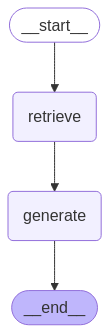

In [24]:
def retrieve(state: State):
    search_results = retriever.vectorstore.similarity_search(state["question"])
    retrieved_docs = retriever.invoke(state["question"])
    return {
        "search_results": search_results,
        "context": retrieved_docs
    }

def generate(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        question=state["question"],
        context=docs_content
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}


graph_builder = StateGraph(State)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()
graph

In [25]:
print(agent_query)
response = graph.invoke({"question": agent_query})
rprint(Pretty(response, max_string=100, no_wrap=False))
rprint(Markdown(response["answer"]))

What is task decomposition for LLM agents?


{
    'question': 'What is task decomposition for LLM agents?',
    'search_results': [
        Document(
            id='c4ce6ad2-f138-4d89-9f78-5fbfd31a5da7',
            metadata={
                'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
                'split_id': '7cb07ff1-7542-400a-859c-053b6e43479c'
            },
            page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA 
complicated ta'+506
        ),
        Document(
            id='069cc00f-92fd-41ae-a8b0-a6a0c63441a4',
            metadata={
                'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
                'split_id': '7cb07ff1-7542-400a-859c-053b6e43479c'
            },
            page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 
min  |  Author'+869
        ),
        Document(
            id='eb349b95-5398-44f4-8bc7-4c8669d9bb5e',
            metadata={
                'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
                'split_id': '3d1901df-c520-4c54-8820-b5971f52380c'
            },
            page_content='Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)\nThe 
system comprises'+288
        ),
        Document(
            id='bcd20973-d3ab-4f4c-9c78-322f66d4f4ca',
            metadata={
                'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
                'split_id': '7cb07ff1-7542-400a-859c-053b6e43479c'
            },
            page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning 
possibilities at each'+544
        )
    ],
    'context': [
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 
min  |  Author'+9646
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='Fig. 7. Comparison of AD, ED, source policy and RL^2 on environments that require memory 
and explora'+9609
        )
    ],
    'answer': 'Task decomposition for LLM (large language model) agents involves breaking down complex tasks into 
s'+1189
}

Task decomposition for LLM (large language model) agents involves breaking down complex tasks into smaller,        
manageable subgoals. This process enables the agents to handle intricate problems more effectively by transforming 
them into simpler steps. There are different approaches to task decomposition:                                     

 1 Chain of Thought (CoT): This method prompts the model to "think step by step," enhancing its performance on     
   complex tasks by guiding it to break down larger tasks into manageable components.                              
 2 Tree of Thoughts: This approach extends the CoT by exploring multiple reasoning possibilities at each step,     
   generating a tree-like structure of potential paths the agent could take.                                       
 3 LLM+P: This method involves using an external classical planner to do long-horizon planning. The LLM translates 
   a problem into a Planning Domain Definition Language (PDDL) format, interacts with the planner to generate a    
   plan, and then translates that back into natural language.                                                      
 4 Human Input: Task decomposition can also be guided through task-specific instructions or human input to define  
   the necessary subgoals for achieving the main task.                                                             

Overall, task decomposition is crucial as it allows LLM agents to plan effectively and manage complex tasks through
a structured approach.

In [26]:
print(human_data_query)
response = graph.invoke({"question": human_data_query})
rprint(Pretty(response, max_string=100, no_wrap=False))
rprint(Markdown(response["answer"]))

What are main steps for collecting human data?


{
    'question': 'What are main steps for collecting human data?',
    'search_results': [
        Document(
            id='17741deb-555b-42e6-9d3c-d66395f8ef40',
            metadata={
                'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/',
                'split_id': 'e1ceb846-4f31-499b-82de-5fbb14f27d22'
            },
            page_content='Fig. 1. Two directions to approach high data quality.\nHuman Raters ↔ Data 
Quality#\nCollecting human '+645
        ),
        Document(
            id='8784a472-61c6-4eb8-8475-b914a3c36e86',
            metadata={
                'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/',
                'split_id': 'e1ceb846-4f31-499b-82de-5fbb14f27d22'
            },
            page_content='Thinking about High-Quality Human Data\n    \nDate: February 5, 2024  |  Estimated 
Reading Time: 21 mi'+769
        ),
        Document(
            id='395c7e46-0ead-4407-8d94-8bb032ca72f6',
            metadata={
                'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/',
                'split_id': '4c32dd6b-d0e0-4cee-b54b-1779b0057a5a'
            },
            page_content='Or\n@article{weng2024humandata,\n  title   = "Thinking about High-Quality Human Data",\n 
author  = "We'+894
        ),
        Document(
            id='4200a164-5345-40c9-9b5d-829a9286fd90',
            metadata={
                'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
                'split_id': '8abfe68d-5cb1-4697-9cd9-e836ee05b300'
            },
            page_content='With the input and the inference results, the AI assistant needs to describe the process 
and results'+444
        )
    ],
    'context': [
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
            page_content='Thinking about High-Quality Human Data\n    \nDate: February 5, 2024  |  Estimated 
Reading Time: 21 mi'+9715
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2024-02-05-human-data-quality/'},
            page_content='Fig. 10. Influence functions values match leave-one-out training results on 10-class 
MNIST. (Image s'+9320
        ),
        Document(
            metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
            page_content='With the input and the inference results, the AI assistant needs to describe the process 
and results'+8583
        )
    ],
    'answer': 'The main steps for collecting high-quality human data include:\n\n1. **Task Design**: Create a clear
a'+1063
}

The main steps for collecting high-quality human data include:                                                     

 1 Task Design: Create a clear and manageable task workflow that enhances understanding and reduces complexity.    
   This may involve developing detailed guidelines, although care should be taken to avoid making them overly      
   complex, as this can require extensive training for annotators.                                                 
 2 Select and Train Raters: Identify a pool of annotators with the appropriate skill set and ensure consistency in 
   their performance. This step includes conducting training sessions for the annotators and providing regular     
   feedback and calibration sessions after onboarding.                                                             
 3 Collect and Aggregate Data: This stage involves the actual collection of labeled data. Machine learning         
   techniques can be employed here to clean and filter the data effectively and to smartly aggregate it to identify
   true labels.                                                                                                    

These steps collectively ensure the quality and reliability of the human-annotated data, which serves as a         
foundation for training machine learning models, especially in tasks such as classification or reinforcement       
learning from human feedback (RLHF) for large language model (LLM) alignment.